Parts of code for interview Capgemini from DAC-PINN.  
Contents:
- library imports
- parameters struct.
- NN architecture.
- Physics loss calculation.
- Dynamic loss weight scaling.

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.constants import gas_constant as R_gas
import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pyDOE import lhs
from scipy import io, stats
from scipy.stats import qmc
import random
import time
import pdb

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cpu


Code for some basics of the modeled system:
- Naming of modeled species.
- Importing of all solid species data.

Definitions and data preparation

In [ ]:
#Define parameters for model in symetrical conditions
class parameters():
    #System description and geometry
    L = 0.025                       # column lenght [m]    
    R = 0.0025                      # column radius [m]
    eps_b = 0.5                     # packed-bed porosity [-]
    rho_p = 744                     # bed density [kg/m3] 
    v_in = 0.1                      # axial velocity [m/s]
    diff_p = 2e-6                   # [m/s]
    D_ax = 7e-4                     # [m2/s]
    D_rad = 1.57e-5                 # [m2/s]             
    R_p = 0.25e-3                   # [m]

    #Variables needed for data NN:
    inputs = 2
    num_outputs = faces_data.shape[2]   # number of ouptuts to predict
    dt = 10                             # time step [s]
    t_end = 8000                        # total simulated time [s]
    Nx = 100                            # number of gridpoints [-]

    x_f = np.linspace(0, L, Nx + 1)     # spatial coordinates of the cell faces [m]
    x_c = 0.5 * (x_f[:-1] + x_f[1:])    # spatial coordinates of the cell centers [m]

    t = np.linspace(0, t_end, int(t_end/dt) + 1)    # time grid [s]                       
    x = np.concatenate((0, x_c), axis=None)         # inlet + cell centers [m]

    x_combined = np.zeros(Nx * 2 + 1)

    # Interplace x_f and x_c
    x_combined[0::2] = x_f
    x_combined[1::2] = x_c
    
    x = x_combined

    #Physical parameters
    T_feed = 25 + 273.15                  # feed temperature [K]
    T_initial = 25 + 273.15               # initial temperature [K]
    T_0 = T_initial
    T_max = faces_data[:,:,2].max()       # max temperature [K]

    frac_CO2 = 400e-6                     # CO2 fraction in the feed [-]
    p_CO2_initial = 0                     # initial CO2 pressure [Pa]
    p_CO2_feed = frac_CO2 * 101325        # feed CO2 pressure [Pa]

    p_tot_initial = 101325                # initial total pressure [Pa]
    p_tot_feed = 101325                   # feed total pressure [Pa]

    MW_CO2 = 44.01/1000                   # molar weight CO2 [kg/mol]
    MW_N2 = 28.0134/1000                  # molar weight N2 [kg/mol]
    
    c_CO2g_feed = p_CO2_feed / R_gas / T_initial + 1e-32        # CO2 gas feed concentration [mol/m3]
    c_N2_feed = (p_tot_feed - p_CO2_feed ) / R_gas / T_feed     # N2 gas feed concentration [mol/m3]
    MW_f = 0.02813337934579806
    rho_f = 1.149925                                            # gas feed density [kg/m3]
    mass_frac_CO2 = c_CO2g_feed * MW_CO2 / rho_f                # CO2 mass fraction in the feed [-]

    a_Cp_p = -3.23e7             # specific heat capacity coefficient particle 'a' [J/K/kg] (Low 2023)
    b_Cp_p = 2.27                # specific heat capacity coefficient particle 'b' [J/kg/K^2] (Low 2023)
    c_Cp_p = -994                # specific heat capacity coefficient particle 'c' [J/kg/K] (Low 2023)
    Cp_g_CO2= 0.84*1000          # specific heat capacity CO2g [J/kg/K] (298K, 1atm) The Engineering Toolbox
    Cp_g_N2= 1.04*1000           # specific heat capacity N2g [J/kg/K] (298K, 1atm) The Engineering Toolbox  

    Cp_p = 1307.444              # specific heat capacity particle [J/kg/K] (Low 2023)
    Cp_f = 29.123/MW_f           # specific heat capacity gas [J/kg/K]

    rho_Cp_ov = (1-eps_b) * rho_p * Cp_p + eps_b * rho_f * Cp_f    # overall heat capacity [J/m3/K]

    lambda_CO2g= 0.0166          # thermal conductivity CO2g [W/m/K] (298K, 1atm) The Engineering Toolbox
    lambda_p =  0.43             # thermal conducitvity particle [W/m/K] (Bos 2019)
    lambda_ov = 0.21             # overall thermal conductivity [W/m/K]

    alpha = lambda_ov / (rho_Cp_ov)          # non-dimensional thermal diffusivity [m2/s]

    v_superficial = v_in/eps_b               # superficial velocity [m/s]

    #Kinetic parametrs  
    k_LDF = 0.005                 # adsorption rate constant[1/s] 

    DH0_CO2 = -70125              # Heat of CO2 adsorption [J/mol] (Low 2023)  
    
    #Thot isotherm parameteres (Young data)
    q_m = 4.86          # [mol/kg]
    T0 = 298.15         # [K]
    b0 = 2.85e-21       # [1/Pa]
    DH0 = -117789       # [J/mol]
    th0 = 0.209
    beta = 0.523
    Young_fact = np.exp(-DH0/R_gas/T_0)

    b_in  = b0 * Young_fact

    #Parameters for non-dimensionalization
    c_0 = c_CO2g_feed                                                   # reference concentration [mol/m3]
    ux_0 = v_superficial                                                # reference velocity [m/s]
    q_0 = q_m*b_in*p_CO2_feed/((1+(b_in*p_CO2_feed)**th0)**(1/th0))     # reference solid concentration (saturation concentration at inlet condition) [mol/kg]
    DeltaT = T_max - T_feed                                             # reference temperature difference [K]
    tau = L / ux_0                                                      # reference time [s]

    Da_I = k_LDF * tau                                                  # non-dimensional adsorption rate constant [-]
    theta = q_0 * (-DH0_CO2) / (rho_Cp_ov * DeltaT) * rho_p * (1-eps_b) # non-dimensional heat of adsorption [-]
    
    Pe_f = ux_0 * L / D_ax                            # Peclet number for flow [-]
    Pe_h = ux_0 * L / alpha                           # Peclet number for heat [-]

    c_tot = p_tot_feed/R_gas/T_feed                   # maximum possiple gas concentration [-]              

    t_nd = t/(tau)                                    # non-dimensional time
    x_nd = x_f/L                                      # non-dimensional space
    t_nd_mesh, x_nd_mesh = np.meshgrid(t_nd, x_nd, indexing='ij')
    
p = parameters()

Non-dimensionalize data:
- Plot concentration curves at different timesteps (truth data)
- Plot heatmap of total concentration evolution across space-time domain (truth data)

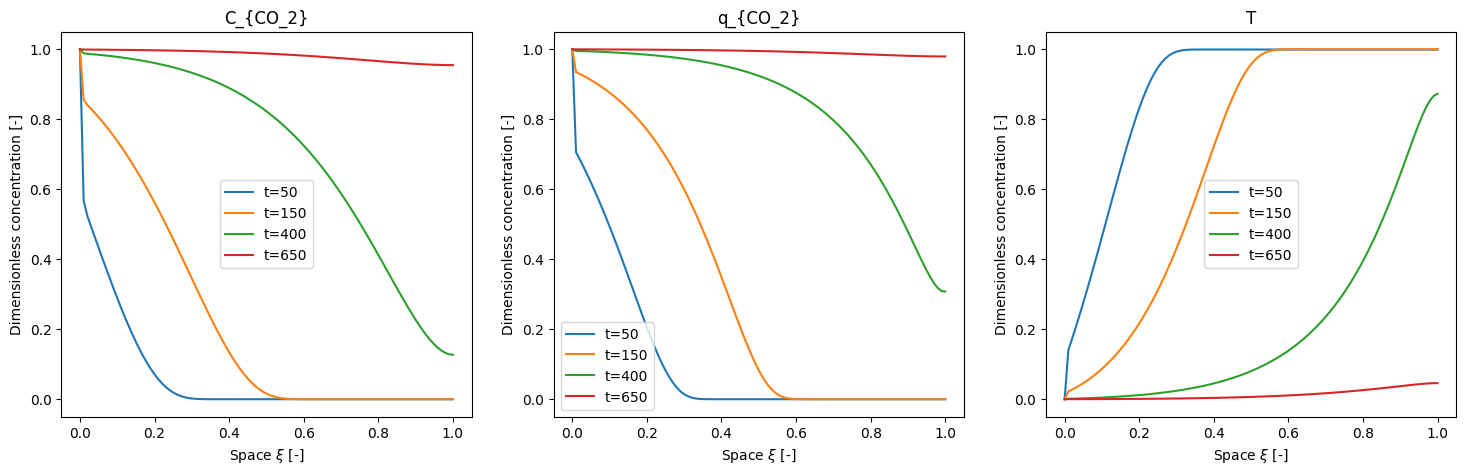
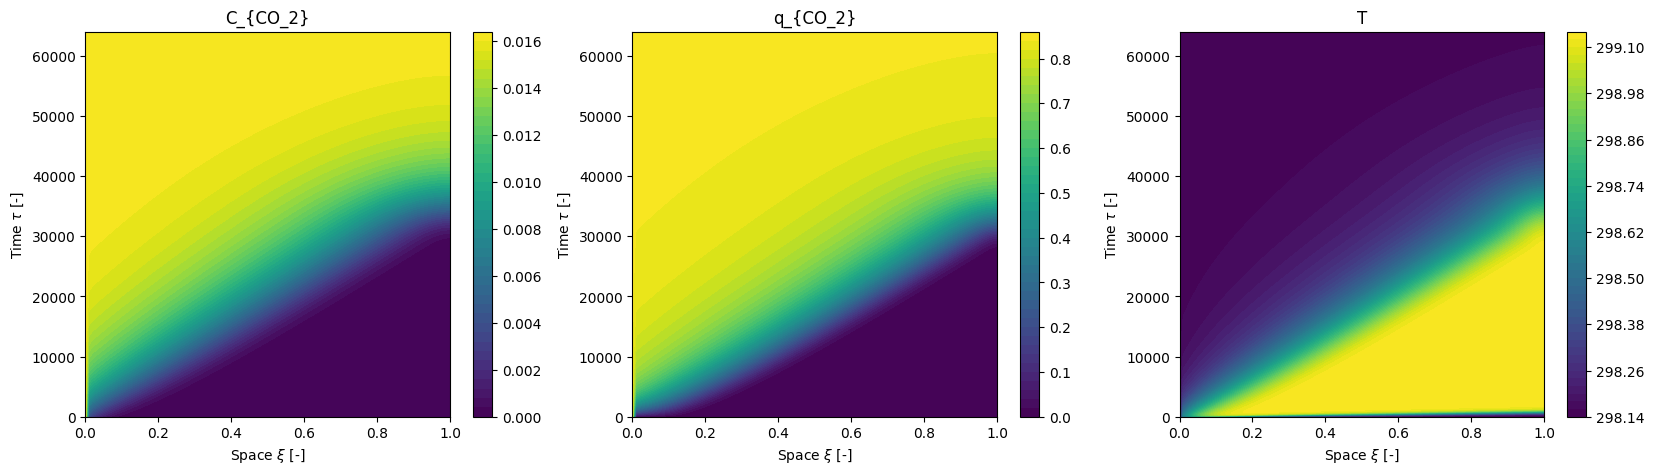


Normalize data and make data sets:
- Training, validation and testing data.
- Boundary condition data.
- Initial condition data.

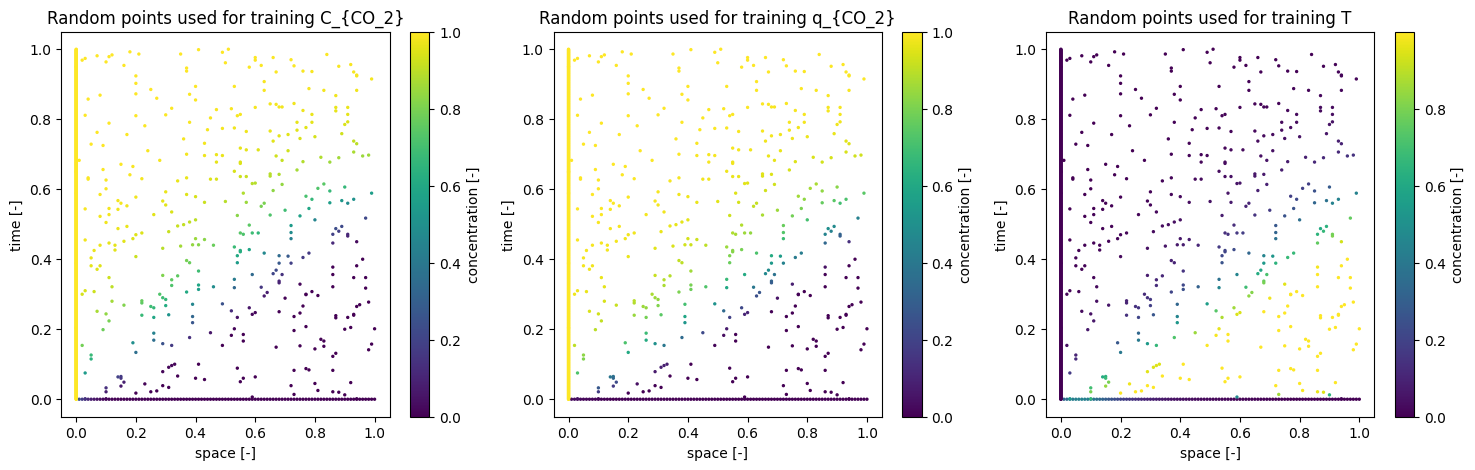
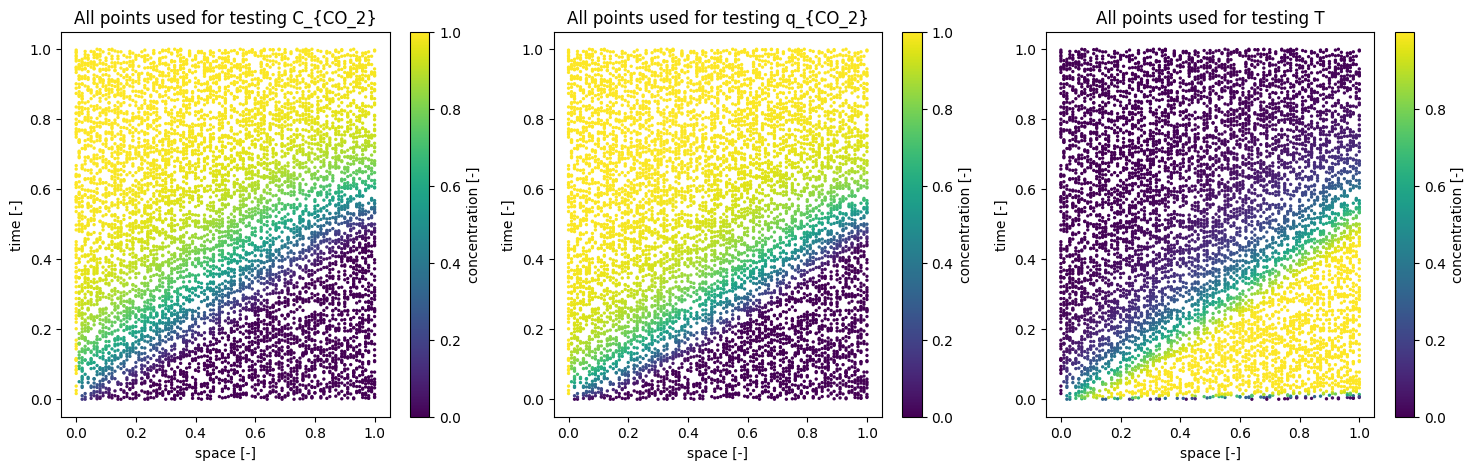

Create PINN architecture:

In [ ]:
# gradient function to obtain gradients of the activation functions

def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

class testnet(nn.Module):   
    def __init__(self, outputs = p.num_outputs, inputs = p.inputs, nodes =96):
        super(testnet, self).__init__()
        self.fc1 = nn.Linear(inputs, nodes)
        self.act1 = nn.Tanh()

        self.fc2 = nn.Linear(nodes, nodes)
        self.act2 = nn.Tanh()

        self.fc3 = nn.Linear(nodes, nodes)
        self.act3 = nn.Tanh()

        self.fc4 = nn.Linear(nodes, nodes)
        self.act4= nn.Tanh()

        self.fc5 = nn.Linear(nodes, outputs)
        self.act5 = nn.Sigmoid()
        
        self.model = nn.Sequential(
                    self.fc1, self.act1, 
                    self.fc2, self.act2, 
                    self.fc3, self.act3, 
                    self.fc4, self.act4, 
                    self.fc5, self.act5
                    )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)


    def forward(self, x):
        x = self.model(x)
        return x
    
    def get_u(self, x):
        u = self.forward(x)
        return u[:,0], u[:,1], u[:,2]

    def get_gradu(self, x):
        co2g, co2s, T = self.get_u(x)
        co2g_t, co2g_x = grad(co2g, x)[:,0], grad(co2g, x)[:,1]
        co2s_t, co2s_x = grad(co2s, x)[:,0], grad(co2s, x)[:,1]
        T_t, T_x = grad(T, x)[:,0], grad(T, x)[:,1]
        return co2g_t, co2s_t, T_t, co2g_x, co2s_x, T_x
    
    def get_grad2u(self,x):
        _, _, _, co2g_x, _, T_x = self.get_gradu(x)
        co2g_xx = grad(co2g_x, x)[:,1]
        T_xx = grad(T_x, x)[:,1]
        return co2g_xx, T_xx

model3comp_non_dim = testnet()
model3comp_non_dim = model3comp_non_dim.to(device)


Create class to get physics loss:
- Generate collocation points.
- Evaluate physics loss.

In [ ]:
# physics loss function

def phys_loss(self):
    # generate collocation points
    lbc, rbc, icpts, pdepts, IC_indices = self.phys_domain_colpts_generator()
    #set non-dimensional velocity
    ux_nd = p.v_superficial/p.ux_0  #in surrogate model this will be calculated using variables.

    #LBC loss Dirichlet
    co2g_lbc, _,  T_lbc = self.model.get_u(lbc)
    lbc_co2g_nd = 1 - co2g_lbc
    lbc_T_nd = T_lbc

    LBC_loss_co2g = torch.mean((lbc_co2g_nd)**2)
    LBC_loss_T = torch.mean((lbc_T_nd)**2)

    #RBC loss Neumann
    _, _, _, dx_co2g_rbc, _, dx_T_rbc = self.model.get_gradu(rbc) 
    rbc_co2g_nd = dx_co2g_rbc
    rbc_T_nd = dx_T_rbc

    RBC_loss_co2g = torch.mean((rbc_co2g_nd)**2)
    RBC_loss_T = torch.mean((rbc_T_nd)**2)
    
    #IC loss (using data)
    cg_ic, cs_ic, T_ic = self.model.get_u(icpts)
    Ric_co2g = cg_ic - torch.tensor(np.repeat(data_faces_nd[0,:,0], self.bcpts/p.Nx)[IC_indices], dtype=torch.float32).to(device)
    Ric_co2s = cs_ic - torch.tensor(np.repeat(data_faces_nd[0,:,1], self.bcpts/p.Nx)[IC_indices], dtype = torch.float32).to(device)
    Ric_T = T_ic - torch.tensor(np.repeat(data_faces_nd[0,:,2], self.bcpts/p.Nx)[IC_indices], dtype = torch.float32).to(device)

    IC_loss_co2g = torch.mean((Ric_co2g)**2)
    IC_loss_co2s = torch.mean((Ric_co2s)**2)
    IC_loss_T = torch.mean((Ric_T)**2)

    #PDE losses: obtain derivativse
    c_nd, q_nd, T_nd = self.model.get_u(pdepts)
    dt_c_nd, dt_q_nd, dt_T_nd, dx_c_nd, _, dx_T_nd = self.model.get_gradu(pdepts)
    dxx_c_nd, dxx_T_nd = self.model.get_grad2u(pdepts)

    #Calculating equilibrium concentration using Toth isotherm
    p_toth = c_nd*p.c_tot*R_gas*(T_nd*p.DeltaT + p.T_0)
    b_toth = p.b0 * torch.exp(p.DH0/( R_gas * p.T_0) * (1 - p.T_0/(T_nd * p.DeltaT + p.T_0))) * p.Young_fact
    th_toth = p.th0 + p.beta*(1 - p.T_0/(T_nd * p.DeltaT + p.T_0))
    q_eq = p.q_m * b_toth * p_toth / ((1 + (b_toth * p_toth)**th_toth)**(1 / th_toth))
    q_eq_nd = q_eq/p.q_0

    #calculate PDE residuals
    pde_co2g = (1/p.t_nd.max())*dt_c_nd +  ux_nd * dx_c_nd  - 1/p.Pe_f * dxx_c_nd \
        + (1-p.eps_b)/p.eps_b * p.q_0/p.c_0 * p.rho_p * p.Da_I * (q_eq_nd - q_nd)

    pde_co2s = (1/p.t_nd.max())*dt_q_nd - p.Da_I * (q_eq_nd - q_nd)

    pde_T = (1/p.t_nd.max())*dt_T_nd + ux_nd * dx_T_nd - 1/p.Pe_h * dxx_T_nd + p.theta * p.Da_I * (q_eq_nd - q_nd)

    PDE_loss_co2g = torch.mean((pde_co2g)**2)
    PDE_loss_co2s = torch.mean((pde_co2s)**2)
    PDE_loss_T = torch.mean((pde_T)**2)
    
    return torch.tensor([LBC_loss_co2g, LBC_loss_T, RBC_loss_co2g, RBC_loss_T, IC_loss_co2g, IC_loss_co2s, IC_loss_T, PDE_loss_co2g, PDE_loss_co2s, PDE_loss_T])


Create dataloader using dataset class.

Initiallize arrays for variable saving.

Start training:
- First use ADAM optimizer with curriculum learning.
- Then use LBFG optimizer.
- Use dynamic loss scaling for multivariable objective function.

In [ ]:
#EMA smoothing function for dynamic loss scaling
def compute_ema_and_scale(phys_loss_array, phys_ema_losses, scaling_factors, alpha):

    # Update EMA values for each physics loss and compute scaling factors
    for i in range(len(phys_loss_array)):
        current_loss = phys_loss_array[i].item()

        # Initialize EMA value if it's the first epoch
        if phys_ema_losses[i] is None:
            phys_ema_losses[i] = current_loss
        else:
            # Update EMA value
            phys_ema_losses[i] = alpha * current_loss + (1 - alpha) * phys_ema_losses[i]

    # Compute the total EMA loss (sum of all EMA losses)
    tot_phys_ema_loss = sum(phys_ema_losses)

    # Compute the scaling factor based on the EMA values
    for i in range(len(phys_loss_array)):
        scaling_factors[i] = tot_phys_ema_loss / (phys_ema_losses[i] + 1e-9)
        #scaling_factors[i] = min(scaling_factors[i], 50)  #possibility of adding a clipping factor
        
    return phys_ema_losses, scaling_factors

Dummy training losses:  

![Dummy loss graphs.png](<attachment:Dummy loss graphs.png>)

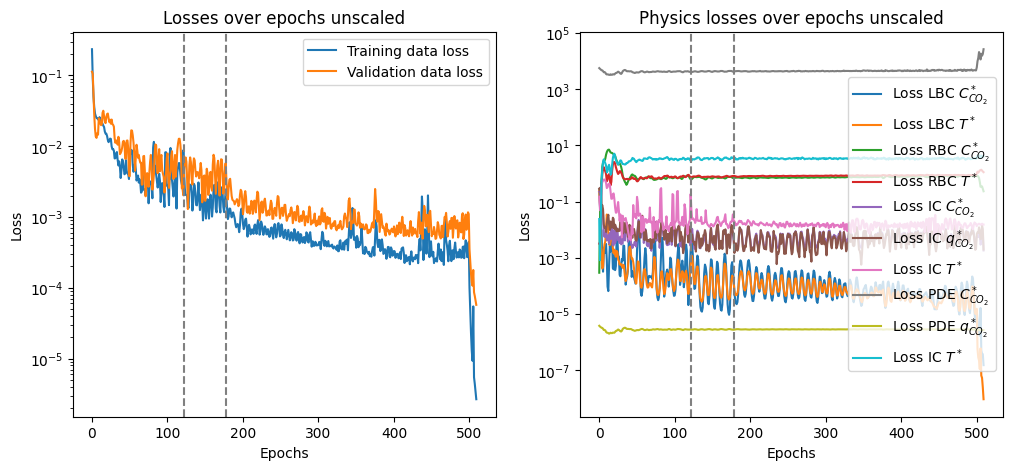

Load best trained networks and predict full domain:
- Print error values.
- Plot predictions and absolute errors.

![Predicted concentration LBFGS.png](<attachment:Predicted concentration LBFGS.png>)
![Absolute error LBFGS.png](<attachment:Absolute error LBFGS.png>)
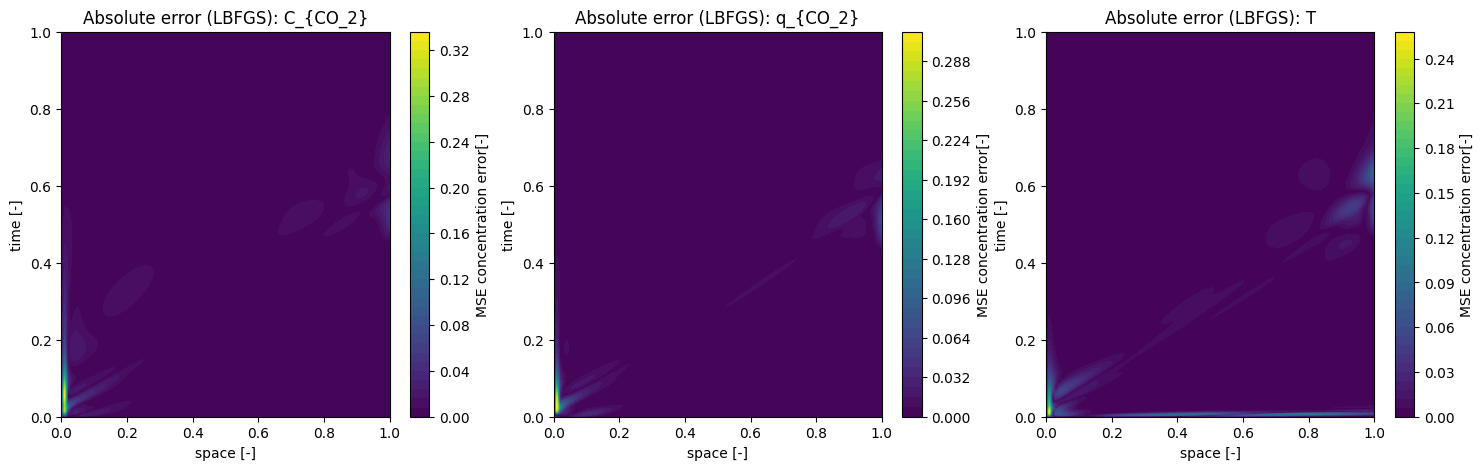
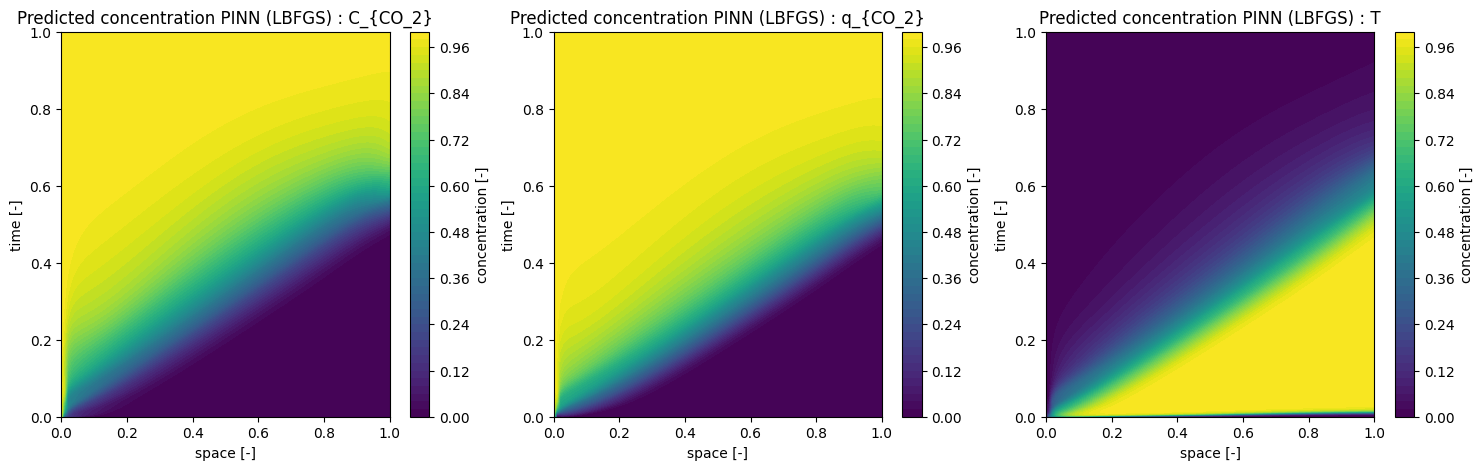